In [49]:
import numpy as np
from numpy import sqrt, exp, sin, cos, pi
from numba import jit
import matplotlib.pyplot as plt
from scipy.special import spherical_jn as jn
from scipy.integrate import dblquad, tplquad
from scipy.interpolate import interp1d
%matplotlib inline
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 8)

from tqdm import tqdm as tqdm
from itertools import product, combinations_with_replacement

In [311]:
run code/correlations.py

In [270]:
D = 10  # Distance of the voids
R = 10  # Smoothing scale of the voids
Rpts = 5 # Smoothing scale of the filament

C = Correlator()
for i, d in enumerate([-D, D]):
    C.add_point([d, 0, 0], ['delta', 'grad_delta', 'hessian'], R,
               constrains={'grad_delta': [0, 0, 0], 
                           'hessian': [np.nan, np.nan, np.nan, 0, 0, 0]},
               name='A_%s' % (i + 1))
C.add_point([0, 0, 0], ['a', 'delta', 'grad_delta', 'hessian'], Rpts,
            constrains = {'delta': [1.68],
                          'grad_delta': [0, 0, 0],
                          'hessian': [np.nan, np.nan, np.nan, 0, 0, 0]},
            name='C')

In [353]:
from scipy.integrate import dblquad
dblquad(integrand,
       0, pi, lambda _: 0, lambda _: 2*pi, args=(2, 0, 0, 0, [0, 0, 0], 1, 1))

(-0.4909257093409829, 2.702487438936102e-10)

8x8: 100%|██████████| 36/36 [00:01<00:00, 31.29it/s]

array([-0.11924023,  0.04857988,  0.04857988,  0.37007111,  0.48670585,
        0.61808679,  0.61808679,  1.92912995])

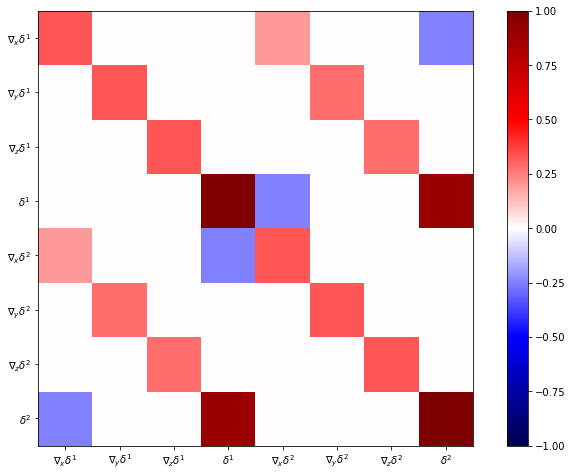

In [341]:
%run code/correlations.py
C = Correlator()
R = 5
#for theta in np.linspace(0, 2*np.pi, 3, endpoint=False):
for x in [0, R]:
    x *= 1 # np.sin(theta) * R
    y = 0 # np.cos(theta) * R
    z = 0
    C.add_point([x, y, z], ['grad_delta', 'delta'], R)
C.plot_cov()
plt.colorbar()

np.linalg.eigvalsh(C.cov)

In [326]:
C.smoothing_scales

[5, 5, 5, 5, 5, 5, 5, 5]

In [283]:
C.cov[0, 5]

-0.24436684598802805

12x12: 100%|██████████| 78/78 [00:01<00:00, 62.01it/s]


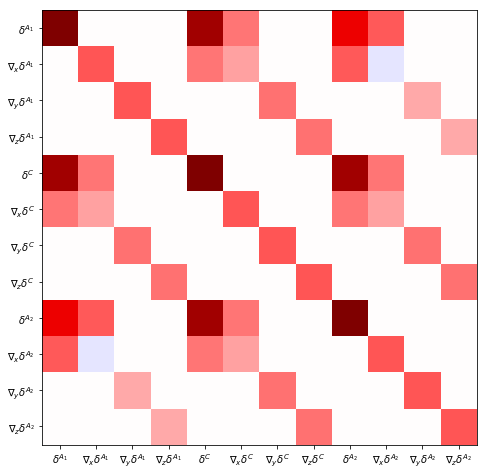

In [230]:
D = 10  # Distance of the voids
R = 10  # Smoothing scale of the voids
Rpts = 5 # Smoothing scale of the filament

C = Correlator()
C.add_point([D, 0, 0], ['delta', 'grad_delta'], R,
               constrains={'grad_delta': [0, 0, 0], 
                           'hessian': [np.nan, np.nan, np.nan, 0, 0, 0]},
               name='A_1')
C.add_point([0, 0, 0], ['delta', 'grad_delta'], R,
            constrains = {'delta': [1.68],
                          'grad_delta': [0, 0, 0],
                          'hessian': [np.nan, np.nan, np.nan, 0, 0, 0]},
            name='C')
C.add_point([-D, 0, 0], ['delta', 'grad_delta'], R,
               constrains={'grad_delta': [0, 0, 0], 
                           'hessian': [np.nan, np.nan, np.nan, 0, 0, 0]},
               name='A_2')

C.plot_cov()

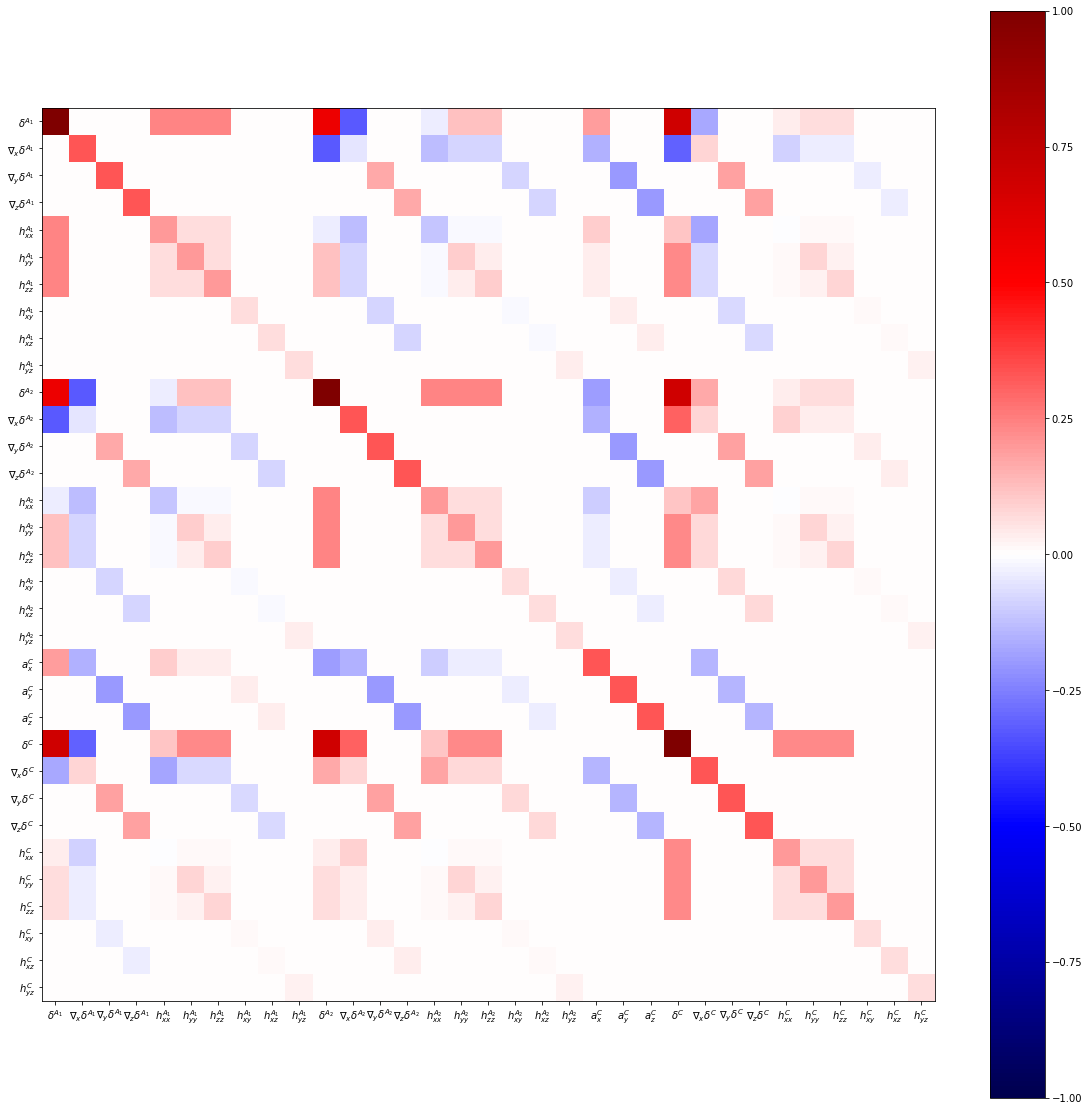

In [192]:
s = slice(0, None, None)

def maskit(A):
    return A # np.where(np.isclose(A, 0), np.nan, A)
plt.figure(figsize=(20, 20))
plt.imshow(maskit(C.cov[s, s]), vmin=-1, vmax=1, cmap='seismic')
labels = C.labels[s]
pos = np.arange(len(labels))
plt.xticks(pos, labels)
plt.yticks(pos, labels)
plt.colorbar()

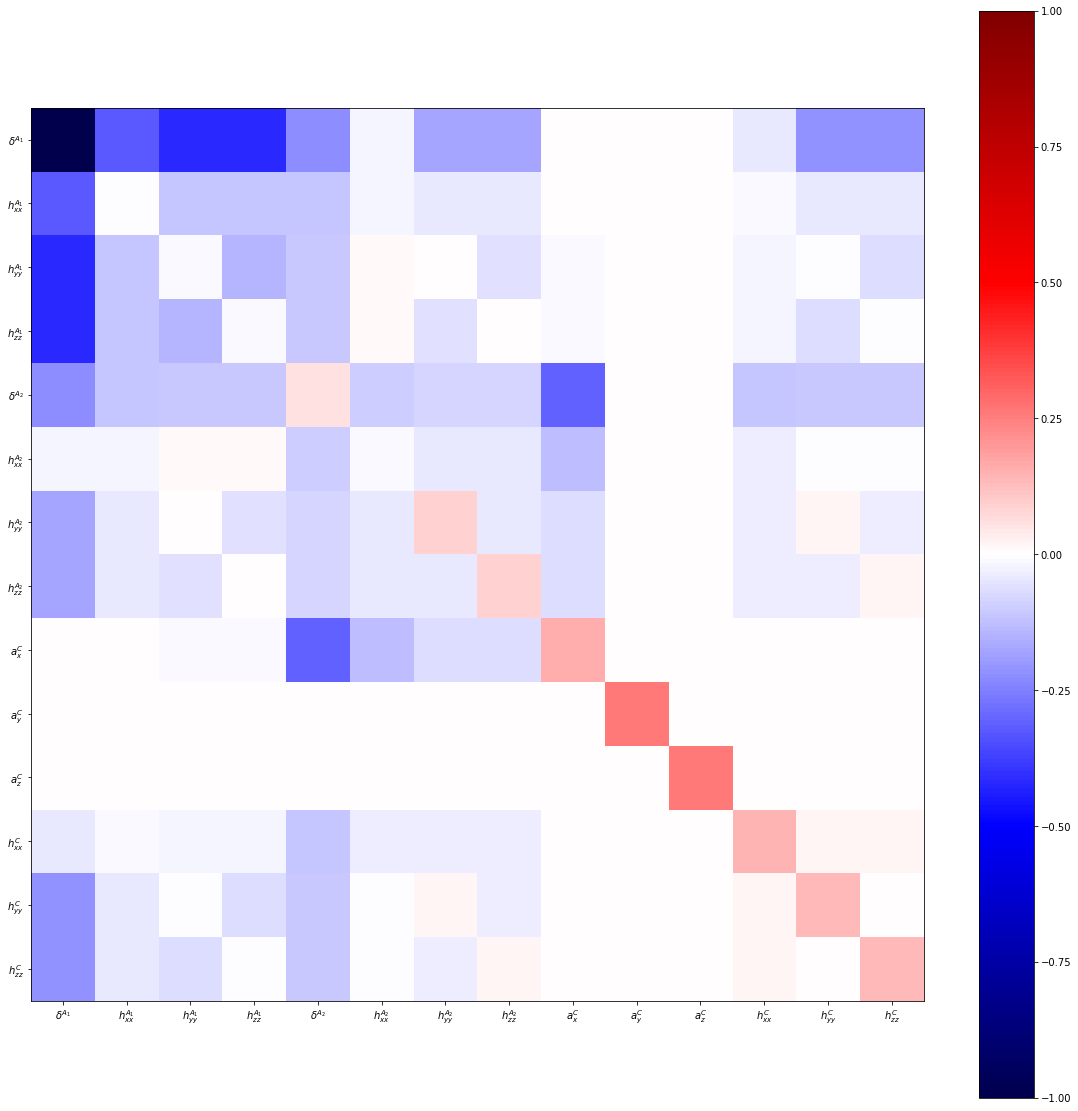

In [194]:
s = slice(0, None, None)

def maskit(A):
    return A # np.where(np.isclose(A, 0), np.nan, A)
plt.figure(figsize=(20, 20))
plt.imshow(maskit(C.cov_c[s, s]), vmin=-1, vmax=1, cmap='seismic')
labels = C.labels_c[s]
pos = np.arange(len(labels))
plt.xticks(pos, labels)
plt.yticks(pos, labels)
plt.colorbar()

In [209]:
cov = C.covariance
np.savez('covariance.npz', cov=cov, D=D, R=R, Rpts=Rpts, Npts=Npts)

140x140: 100%|██████████| 9870/9870 [02:44<00:00, 60.04it/s]


## Plotting the constrains

Use this to restore from the disk

In [5]:
f = np.load('covariance.npz')
cov, D, R, Rpts, Npts = f['cov'], f['D'], f['R'], f['Rpts'], f['Npts']
C = Correlator(D=D, R=R, Rpts=Rpts, Npts=Npts)
C._covariance = cov

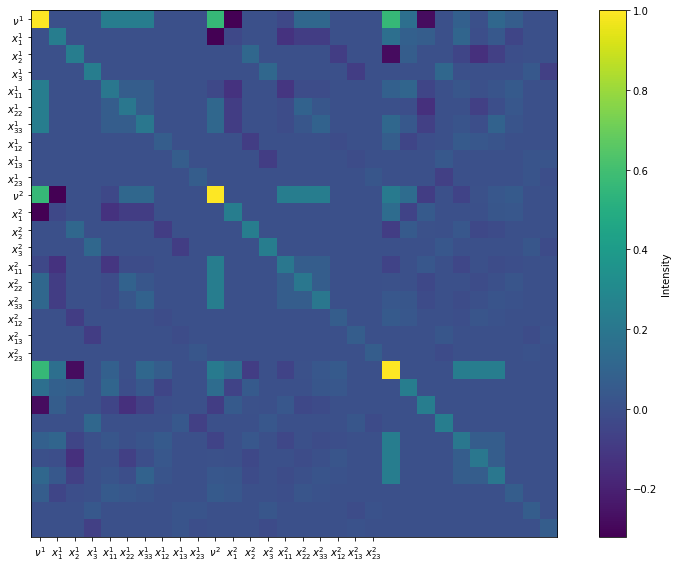

In [10]:
plt.imshow(cov[:30, :30])
C = plt.colorbar()
C.set_label('Intensity')

ticks = list(range(20))
tick_labels = [r'\nu', 'x_1', 'x_2', 'x_3', 'x_{11}', 'x_{22}', 'x_{33}', 'x_{12}', 'x_{13}', 'x_{23}'] * 2
plt.xticks(ticks, ['$%s^%s$' % (s, 1 if i < 10 else 2) for (i, s) in enumerate(tick_labels)])
_ = plt.yticks(ticks, ['$%s^%s$' % (s, 1 if i < 10 else 2) for (i, s) in enumerate(tick_labels)])

plt.tight_layout()
plt.savefig('covariance.pdf')

In [42]:
mean = np.zeros(34)
cov = cov
cons = np.zeros_like(mean) * np.nan

# Impose zero gradient
cons[[1, 2, 3, 11, 12, 13, 21, 22, 23, 31, 32, 33]] = 0
# Impose heigth of center
cons[30] = 1.68

mean_c, cov_c = constrain(mean, cov[:34, :34], cons)

In [12]:
np.random.seed(16091992)
sample = np.random.multivariate_normal(mean_c, cov_c, 5000000)

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: covariance is not positive-semidefinite.
  from ipykernel import kernelapp as app


In [13]:
# Indexes of the matrix element
mapping = np.array([[1, 4, 5], 
                    [4, 2, 6], 
                    [5, 6, 3]])

# Compute the eigenvalues of the three points
hij1 = np.linalg.eigvalsh(sample[:, mapping   ])
hij2 = np.linalg.eigvalsh(sample[:, mapping+ 7])
hij3 = np.linalg.eigvalsh(sample[:, mapping+14])
# TODO quick draws where the height is inversed by swapping them
mask = (np.sum(hij1 < 0, axis=1) == 2) & (np.sum(hij2 < 0, axis=1) == 2) & (np.sum(hij3 < 0, axis=1) == 2) & (sample[:, 0] >= sample[:, 7]) & (sample[:, 7] >= sample[:, 14]) 
print('%s samples (%.3f%%)' % (mask.sum(), mask.sum() / len(mask)))

96239 samples (0.019%)


In [14]:
hij = np.concatenate((hij1[mask].T, hij2[mask].T, hij3[mask].T)).T
weights = np.product(hij, axis=1)

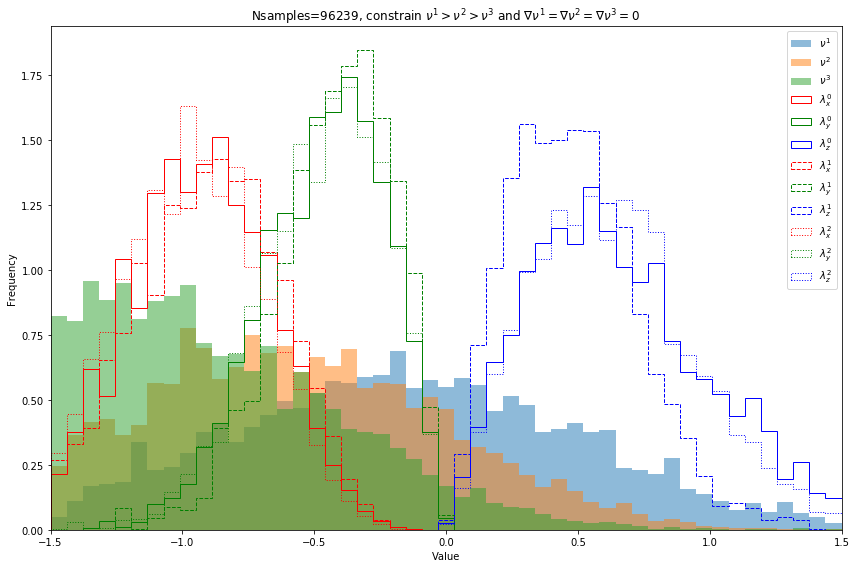

In [23]:
from cycler import cycler

bins = np.linspace(-1.5, 1.5, 50)
kwa = dict(bins=bins, normed=True, alpha=0.5, weights=weights, histtype='stepfilled')
plt.hist(sample[mask, 0], label=r'$\nu^1$', **kwa)
plt.hist(sample[mask, 7], label=r'$\nu^2$', **kwa)
plt.hist(sample[mask, 14], label=r'$\nu^3$', **kwa)

cs = cycler(ls=('solid','dashed', 'dotted')) * cycler(color=('red', 'green', 'blue'))

for i, style in enumerate(cs):
    ii = i // 3
    kwa = dict(bins=bins, histtype='step', normed=True, weights=weights)
    plt.hist(hij[:, i], label='$\lambda^{%s}_%s$' % (ii, 'xyz'[i % 3]),
             **kwa, **style)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.xlim(bins.min(), bins.max())
plt.title(r'Nsamples=%s, constrain $\nu^1 > \nu^2 > \nu^3$ and $\nabla \nu^1 = \nabla \nu^2 = \nabla \nu^3 = 0 $ ' % (mask.sum()))
plt.tight_layout()
plt.savefig('distribution_eigvals.pdf', format='pdf')

In [24]:
np.round([sample[mask, 0].mean(), sample[mask, 7].mean(), sample[mask, 14].mean()], 3)

array([ 0.074, -0.374, -0.886])

In [18]:
from corner import corner

In [26]:
hij.shape

(96239, 9)

In [35]:
sampleplot = np.concatenate([[sample[mask, 0], sample[mask, 7], sample[mask, 14]], hij.T]).T
sampleplot.shape

(96239, 12)

In [ ]:
N = 12
labels = [r'$%s$' % e for e in r'\nu^1 \nu^2 \nu^3 h^1_{xx} h^1_{yy} h^1_{zz} h^2_{xx} h^2_{yy} h^2_{zz} h^3_{xx} h^3_{yy} h^3_{zz}'.split()][:N]
foo = corner(sample[mask, :N], bins=20, weights=weights, quantiles=[0.05, 0.5, 0.95], labels=labels)

plt.savefig('corner.pdf')

## Constrained to $\nabla \nu=0$

Use this to restore from the disk

In [281]:
f = np.load('covariance.npz')
cov, D, R, Rpts, Npts = f['cov'], f['D'], f['R'], f['Rpts'], f['Npts']
C = Correlator(D=D, R=R, Rpts=Rpts, Npts=Npts)
C._covariance = cov

In [282]:
mean_c, cov_c = C.constrain(delta_center=1.68, delta_peaks=[0.074, -0.373, -0.887])

Text(0,0.5,'$\\nu$')

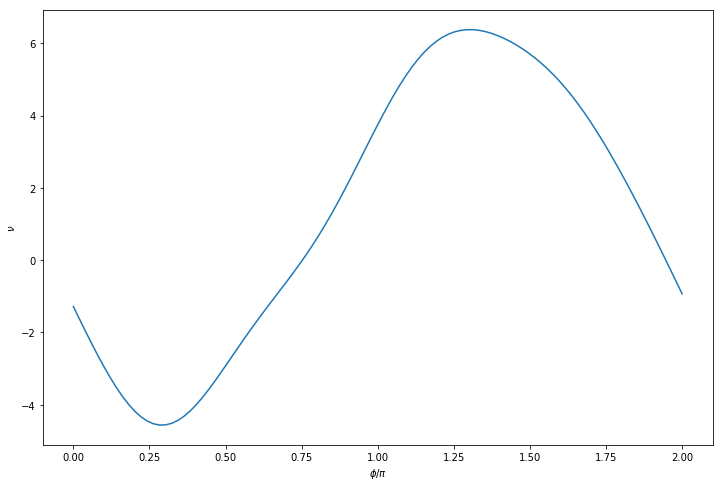

In [292]:
plt.plot(np.linspace(0, 2, 100), mean_c[-100:])
plt.xlabel('$\phi/\pi$')
plt.ylabel(r'$\nu$')

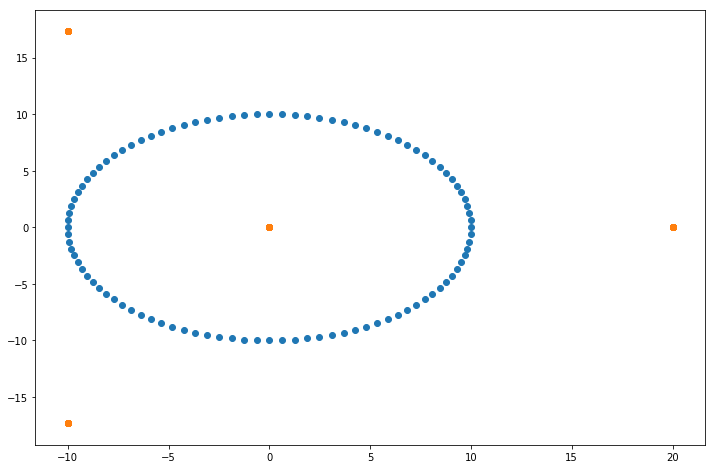

In [289]:
C.plot()

# TODO:
- compute correlation in $(u_r, u_\theta, u_z)$ instead of $(u_x, u_y, u_z)$
- impose orientation of hessian $e_1 = u_r, e_2 = u_\theta, e_3 = u_z$ and $\lambda_1 \leq \lambda_2 \leq 0 \leq \lambda_3$.